# Random forest in scikit-learn

We illustrate the following regression method on a data set called "Hitters", which includes 20 variables and 322 observations of major league baseball players. The goal is to predict a baseball player’s salary on the basis of various features associated with performance in the previous year. We don't cover the topic of exploratory data analysis in this notebook. 

- Visit [this documentation](https://cran.r-project.org/web/packages/ISLR/ISLR.pdf) if you want to learn more about the data

## Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import OrderedDict

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

## Data

### Import

In [2]:

df = pd.read_csv("https://raw.githubusercontent.com/kirenz/datasets/master/Hitters.csv")

In [3]:
df

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,497,127,7,65,48,37,5,2703,806,32,379,311,138,N,E,325,9,3,700.0,N
318,492,136,5,76,50,94,12,5511,1511,39,897,451,875,A,E,313,381,20,875.0,A
319,475,126,3,61,43,52,6,1700,433,7,217,93,146,A,W,37,113,7,385.0,A
320,573,144,9,85,60,78,8,3198,857,97,470,420,332,A,E,1314,131,12,960.0,A


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      322 non-null    int64  
 1   Hits       322 non-null    int64  
 2   HmRun      322 non-null    int64  
 3   Runs       322 non-null    int64  
 4   RBI        322 non-null    int64  
 5   Walks      322 non-null    int64  
 6   Years      322 non-null    int64  
 7   CAtBat     322 non-null    int64  
 8   CHits      322 non-null    int64  
 9   CHmRun     322 non-null    int64  
 10  CRuns      322 non-null    int64  
 11  CRBI       322 non-null    int64  
 12  CWalks     322 non-null    int64  
 13  League     322 non-null    object 
 14  Division   322 non-null    object 
 15  PutOuts    322 non-null    int64  
 16  Assists    322 non-null    int64  
 17  Errors     322 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  322 non-null    object 
dtypes: float64

### Missing values

Note that the salary is missing for some of the players:

In [5]:
print(df.isnull().sum())

AtBat         0
Hits          0
HmRun         0
Runs          0
RBI           0
Walks         0
Years         0
CAtBat        0
CHits         0
CHmRun        0
CRuns         0
CRBI          0
CWalks        0
League        0
Division      0
PutOuts       0
Assists       0
Errors        0
Salary       59
NewLeague     0
dtype: int64


We simply drop the missing cases: 

In [6]:
# drop missing cases
df = df.dropna()

### Create label and features

Since we will use algorithms from scikit learn, we need to encode our categorical features as one-hot numeric features (dummy variables):

In [7]:
dummies = pd.get_dummies(df[['League', 'Division','NewLeague']])

In [8]:
dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   League_A     263 non-null    uint8
 1   League_N     263 non-null    uint8
 2   Division_E   263 non-null    uint8
 3   Division_W   263 non-null    uint8
 4   NewLeague_A  263 non-null    uint8
 5   NewLeague_N  263 non-null    uint8
dtypes: uint8(6)
memory usage: 3.6 KB


In [9]:
print(dummies.head())

   League_A  League_N  Division_E  Division_W  NewLeague_A  NewLeague_N
1         0         1           0           1            0            1
2         1         0           0           1            1            0
3         0         1           1           0            0            1
4         0         1           1           0            0            1
5         1         0           0           1            1            0


Next, we create our label y:

In [10]:
y = df[['Salary']]

We drop the column with the outcome variable (Salary), and categorical columns for which we already created dummy variables:

In [11]:
X_numerical = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')

Make a list of all numerical features (we need them later):

In [12]:
list_numerical = X_numerical.columns
list_numerical

Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists',
       'Errors'],
      dtype='object')

In [13]:
# Create all features
X = pd.concat([X_numerical, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   AtBat        263 non-null    float64
 1   Hits         263 non-null    float64
 2   HmRun        263 non-null    float64
 3   Runs         263 non-null    float64
 4   RBI          263 non-null    float64
 5   Walks        263 non-null    float64
 6   Years        263 non-null    float64
 7   CAtBat       263 non-null    float64
 8   CHits        263 non-null    float64
 9   CHmRun       263 non-null    float64
 10  CRuns        263 non-null    float64
 11  CRBI         263 non-null    float64
 12  CWalks       263 non-null    float64
 13  PutOuts      263 non-null    float64
 14  Assists      263 non-null    float64
 15  Errors       263 non-null    float64
 16  League_N     263 non-null    uint8  
 17  Division_W   263 non-null    uint8  
 18  NewLeague_N  263 non-null    uint8  
dtypes: float

In [27]:
# Create a list of feature names
feature_names = X.columns

### Split data

Split the data set into train and test set with the first 70% of the data for training and the remaining 30% for testing.

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [15]:
X_train.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,League_N,Division_W,NewLeague_N
260,496.0,119.0,8.0,57.0,33.0,21.0,7.0,3358.0,882.0,36.0,365.0,280.0,165.0,155.0,371.0,29.0,1,1,1
92,317.0,78.0,7.0,35.0,35.0,32.0,1.0,317.0,78.0,7.0,35.0,35.0,32.0,45.0,122.0,26.0,0,0,0
137,343.0,103.0,6.0,48.0,36.0,40.0,15.0,4338.0,1193.0,70.0,581.0,421.0,325.0,211.0,56.0,13.0,0,0,0
90,314.0,83.0,13.0,39.0,46.0,16.0,5.0,1457.0,405.0,28.0,156.0,159.0,76.0,533.0,40.0,4.0,0,1,0
100,495.0,151.0,17.0,61.0,84.0,78.0,10.0,5624.0,1679.0,275.0,884.0,1015.0,709.0,1045.0,88.0,13.0,0,0,0


In [16]:
y_train

,Salary
260,875.0
92,70.0
137,430.0
90,431.5
100,2460.0
...,...
274,200.0
196,587.5
159,200.0
17,175.0


### Data standardization

- Some of our models perform best when all numerical features are centered around 0 and have variance in the same order (like Lasso, Ridge or GAMs).
- To avoid [data leakage](https://en.wikipedia.org/wiki/Leakage_(machine_learning)), the standardization of numerical features should always be performed after data splitting and only from training data. 
- Furthermore, we obtain all necessary statistics for our features (mean and standard deviation) from training data and also use them on test data. Note that we don't standardize our dummy variables (which only have values of 0 or 1).

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train[list_numerical]) 

X_train[list_numerical] = scaler.transform(X_train[list_numerical])
X_test[list_numerical] = scaler.transform(X_test[list_numerical])

- Make contiguous flattened arrays (for our scikit-learn model):

In [20]:
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

## Model

- Define hyperparameters:

In [21]:
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "warm_start":True,
    "oob_score":True,
    "random_state": 42,
}

- Build and fit model

In [22]:
reg =RandomForestRegressor(**params)

reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=4, min_samples_split=5, n_estimators=500,
                      oob_score=True, random_state=42, warm_start=True)

- Make predictions

In [23]:
y_pred = reg.predict(X_test)

- Evaluate model with RMSE

In [24]:
mean_squared_error(y_test, y_pred, squared=False)

296.37036964432764

## Feature importance

- Next, we take a look at the tree based feature importance and the permutation importance.

### Mean decrease in impurity (MDI)

- Mean decrease in impurity (MDI) is a measure of feature importance for decision tree models. 

```{Note}
Visit [this notebook](https://kirenz.github.io/feature-engineering/docs/mdi.html#) to learn more about MDI
```

- Feature importances are provided by the fitted attribute `feature_importances_` 


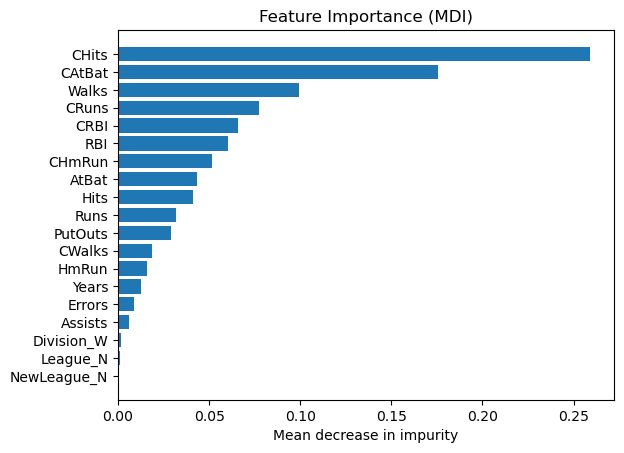

In [28]:
# obtain feature importance
feature_importance = reg.feature_importances_

# sort features according to importance
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0])

# plot feature importances
plt.barh(pos, feature_importance[sorted_idx], align="center")

plt.yticks(pos, np.array(feature_names)[sorted_idx])
plt.title("Feature Importance (MDI)")
plt.xlabel("Mean decrease in impurity");

### Permutation feature importance

The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled. 

```{Note}
Visit [this notebook](https://kirenz.github.io/feature-engineering/docs/permutation-feature-importance.html) to learn more about permutation feature importance.
```

In [29]:
result = permutation_importance(
    reg, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

tree_importances = pd.Series(result.importances_mean, index=feature_names)

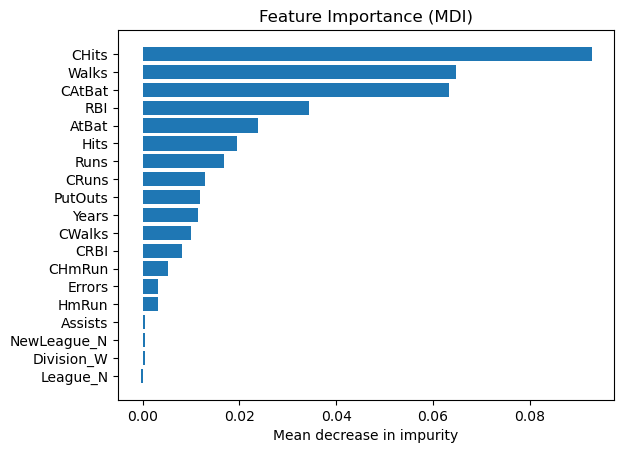

In [30]:
# sort features according to importance
sorted_idx = np.argsort(tree_importances)
pos = np.arange(sorted_idx.shape[0])

# plot feature importances
plt.barh(pos, tree_importances[sorted_idx], align="center")

plt.yticks(pos, np.array(feature_names)[sorted_idx])
plt.title("Feature Importance (MDI)")
plt.xlabel("Mean decrease in impurity");

- Same data plotted as boxplot:

Text(0.5, 1.0, 'Permutation Importance (test set)')

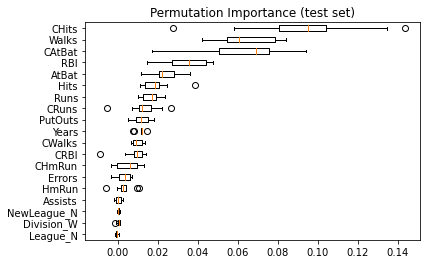

In [ ]:
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names)[sorted_idx],
)

plt.title("Permutation Importance (test set)")

- We observe that the same features are detected as most important using both methods (e.g., `CAtBat`, `CRBI`, `CHits`, `Walks`, `Years`). Although the relative importances vary (especially for feature `Years`).